In [2]:
import numpy as np
import pandas as pd
import os


%matplotlib inline
import cv2
import random
import tqdm
from tqdm import notebook
import matplotlib.pyplot as plt

import torch
from PIL import Image
import torch.nn as nn
from torchviz import make_dot

In [3]:
import segmentation_models_pytorch as seg_models

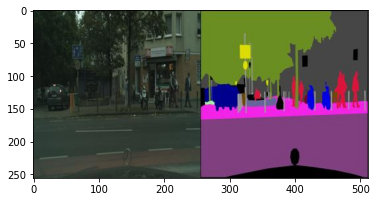

In [4]:
image_dir = r"D:\PyTorch\Project_6_CityScapes_Segmentation\input\archive_1\cityscapes_data"
train_images = os.path.join(image_dir, 'train')
val_images = os.path.join(image_dir, 'val')

train_files = os.listdir(train_images)
val_files = os.listdir(val_images)

# Print any image of your choice from the training set
s_no = 20

img = Image.open(os.path.join(train_images, train_files[s_no])).convert("RGB")

plt.imshow(img)
plt.show()

In [5]:
class data_load(object):
    def __init__(self, images_dir, batch_size, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(data_load, self).__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.target_size = target_size
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.step_number = 0
        self.total_steps = int(len(self.filenames) // self.batch_size)
        
    def generate_batch(self):
        start = self.step_number * self.batch_size
        stop = (self.step_number + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]
        
        images_batch = [cv2.imread(filename) for filename in filenames_batch]
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])
        
        # To separate images and their labels
        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch])
        
        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        images_batch /= self.rescale
        images_batch = np.moveaxis(images_batch, 1, 0)
        
        return torch.Tensor(images_batch)
    
    def __next__(self):
        if self.step_number > self.total_steps:
            self.step_number = 0
        images, masks = self.generate_batch()
        self.step_number += 1
        return images, masks
    
    def __len__(self):
        return self.total_steps

In [6]:
names = ["PSPNet", "UNet", "Unet++", "FPN", "DeepLab V3", "DeepLab V3+"]
models_dict = {
    "PSPNet": seg_models.PSPNet(classes=3),
    "UNet": seg_models.Unet(classes=3),
    "Unet++": seg_models.UnetPlusPlus(classes=3),
    "FPN": seg_models.FPN(classes=3),
    "DeepLab V3": seg_models.DeepLabV3(classes=3),
    "DeepLab V3+": seg_models.DeepLabV3Plus(classes=3),
}

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\91944/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [7]:
def dice(pred, label):
    pred = (pred > 0).float()
    return 2. * (pred*label).sum() / (pred+label).sum()

In [8]:
def training(model, epochs, batch_size):
 
    train_generator = data_load(images_dir = train_images, batch_size = batch_size, rescale = 255.0)
    test_generator = data_load(images_dir = val_images, batch_size = batch_size, rescale = 255.0)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    main_pbar = tqdm.notebook.tqdm(range(epochs))
    main_pbar.set_description('common progress ')
    
    for epoch in main_pbar:
        running_params = dict(train_loss = [], 
                               train_dice = [], 
                               test_loss = [], 
                               test_dice = [])
        train_pbar = tqdm.notebook.tqdm(range(len(train_generator)))
        
        for step in train_pbar:
             
            train_imgs, train_masks = next(train_generator)
            train_imgs, train_masks = train_imgs.to(device), train_masks.to(device)
            
            optimizer.zero_grad()
            
            train_predictions = model(train_imgs)

            train_loss = criterion(train_predictions, train_masks)
            train_loss.backward()
            
            train_dice = dice(pred = train_predictions, label = train_masks)
            
            optimizer.step()
        
        
       
            with torch.no_grad():
                test_images, test_masks = next(test_generator)
                test_images, test_masks = test_images.to(device), test_masks.to(device)
            
                test_predictions = model(test_images)
    
                test_loss = criterion(test_predictions, test_masks)
        
                test_dice = dice(pred = test_predictions, label = test_masks)
                
            
            current_metrics = dict(train_loss = [train_loss.item(), ], 
                                   train_dice = [train_dice.item(), ], 
                                   test_loss = [test_loss.item(),], 
                                   test_dice = [test_dice.item(),])
            
            running_params.update(current_metrics)
            
            mean_metrics = dict(zip(running_params.keys(), [(sum(tensor) / (step + 1)) for tensor in running_params.values()]))
    
            train_pbar.set_postfix(mean_metrics)
            torch.cuda.empty_cache()
        
        temp = [train_loss.item(), train_dice.item(), test_loss.item(), test_dice.item()]
        logs.append(temp)
        history.update(running_params)
        best_loss = max(history['test_loss'])
        best_loss_index =  history['test_loss'].index(best_loss)
        current_loss_index = history['test_loss'].index(test_loss.item())
        if abs(current_loss_index - best_loss_index) >= 5:
            for param_group in optim.param_groups:
                if param_group['lr'] * 0.1 > 1e-6:
                    print('reduce learning rate to', {param_group['lr'] * 0.1})
                    param_group['lr'] *= 0.1

In [16]:
histories = []   

for model_name, model_instance in models_dict.items():
    name = model_name
    model_name = model_instance
    model_name.to("cuda:0")
    x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
    x = x.to("cuda:0")
    outputs_x = model_name(x)
    make_dot(outputs_x, params=dict(list(model_name.named_parameters())))
    
    optimizer = torch.optim.Adam(params = model_name.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)

    criterion = torch.nn.BCEWithLogitsLoss()

    history = dict(train_loss = [], 
                   train_dice = [], 
                   test_loss = [], 
                   test_dice = [])
    
    logs = []
    
    training(model = model_name, epochs = 2, batch_size = 32)
    
    histories.append(logs)
    
    # Saving the model weights for each model in working directory
    working_dir = r"D:\PyTorch\Project_6_CityScapes_Segmentation"
    weights_path = r"D:\PyTorch\Project_6_CityScapes_Segmentation\notebooks"
    logs_path = os.path.join(working_dir, name + '_logs')
    torch.save({ 
    'model_state_dict': model_name.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, "best_jupy.pt")
   # torch.save(model_name.state_dict(), weights_path)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

In [11]:
os.getcwd()

'D:\\PyTorch\\Project_6_CityScapes_Segmentation\\notebooks'

In [19]:
train_generator = data_load(images_dir = train_images, batch_size = 16, rescale = 255.0)
train_imgs, train_masks = next(train_generator)

In [22]:
train_imgs.shape, train_masks.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 3, 128, 128]))

In [29]:
model_name(train_imgs.cuda()).shape

torch.Size([16, 3, 128, 128])

In [3]:
import torch